# Modelando con Nones/Without Outliers

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from fbprophet import Prophet
from fbprophet.diagnostics import cross_validation
from sklearn.metrics import mean_squared_error, mean_absolute_error
import warnings
warnings.simplefilter("ignore")

plt.style.use('bmh')

In [2]:
def mape(y_true, y_pred):
    y_true, y_pred=np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true-y_pred)/y_true))*100

def smape(y_true,y_pred):
    return ((y_true - y_pred).abs() / (y_true.abs() + y_pred.abs())).mean() * 200

In [3]:
miguel = pd.read_csv("../data_clean/miguel_pm10_clean_v2.csv",index_col=[1])
#cuauh = pd.read_csv("cuauh_pm10_clean.csv",index_col=[1])
#benito = pd.read_csv("benito_pm10_clean.csv",index_col=[1])

miguel.drop("Unnamed: 0",axis=1,inplace=True)
#cuauh.drop("Unnamed: 0",axis=1,inplace=True)
#benito.drop("Unnamed: 0",axis=1,inplace=True)

In [4]:
miguel_modelo= miguel.drop(["FECHA","HORA"],axis=1)
#cuauh_modelo= cuauh.drop(["FECHA","HORA","AÑO","MES"],axis=1)
split_date='2019-01-01'

train1=miguel_modelo[miguel_modelo.index<=split_date].copy()
test1=miguel_modelo[miguel_modelo.index>split_date].copy()

#train2=cuauh_modelo[cuauh_modelo.index<=split_date].copy()
#test2=cuauh_modelo[cuauh_modelo.index>split_date].copy()

In [5]:
miguel_modelo=miguel_modelo.reset_index().rename(columns={'DATETIME':'ds','MGH':'y'})
train1=train1.reset_index().rename(columns={'DATETIME':'ds','MGH':'y'})
test1=test1.reset_index().rename(columns={'DATETIME':'ds','MGH':'y'})

#train2=train2.reset_index().rename(columns={'DATETIME':'ds','HGM':'y'})
#test2=test2.reset_index().rename(columns={'DATETIME':'ds','HGM':'y'})

train1.ds=pd.to_datetime(train1.ds)
#train2.ds=pd.to_datetime(train2.ds)
test1.ds=pd.to_datetime(test1.ds)
#test2.ds=pd.to_datetime(test2.ds)

#train2.head()

## Modelando

In [ ]:
modelo1=Prophet(n_changepoints=15,
               changepoint_prior_scale=0.6,
               #seasonality_prior_scale = 10
              ).fit(train1)
pred1=modelo1.predict(test1)

In [ ]:
mape(test1.y, pred1.yhat), smape(test1.y, pred1.yhat)

In [ ]:
mean_squared_error(test1.y, pred1.yhat)**0.5,mean_absolute_error(test1.y, pred1.yhat)

In [ ]:
f, ax=plt.subplots(1)
f.set_figheight(8)
f.set_figwidth(20)
ax.scatter(test.ds, test.y, color='r',s=11)
fig=modelo.plot(pred, ax)

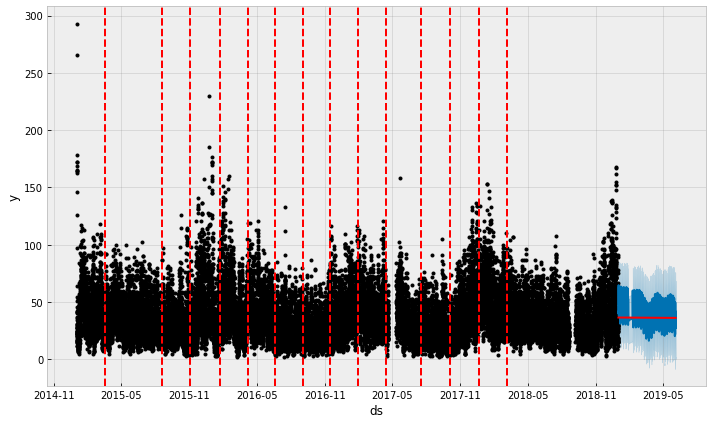

In [9]:
from fbprophet.plot import add_changepoints_to_plot
#ploteando change_pints del modelo A
fig = modelo1.plot(pred1)
a = add_changepoints_to_plot(fig.gca(), modelo1, pred1)

## Modelando "make_future"

In [10]:
test1.shape

(3274, 2)

In [11]:
test1.tail() #2019-06-04 08:00:00

,ds,y
3269,2019-06-04 04:00:00,25.0
3270,2019-06-04 05:00:00,19.0
3271,2019-06-04 06:00:00,25.0
3272,2019-06-04 07:00:00,18.0
3273,2019-06-04 08:00:00,26.0


In [12]:
test1.head() #2019-01-01 01:00:00

,ds,y
0,2019-01-01 01:00:00,119.0
1,2019-01-01 02:00:00,124.0
2,2019-01-01 03:00:00,143.0
3,2019-01-01 04:00:00,168.0
4,2019-01-01 05:00:00,164.0


In [13]:
modelo2=Prophet(n_changepoints=15,
                    changepoint_prior_scale=0.65,
                    #seasonality_prior_scale = 10
                    ).fit(train1)

In [14]:
future = modelo2.make_future_dataframe(freq='H',periods=3274)
forecast = modelo2.predict(future)

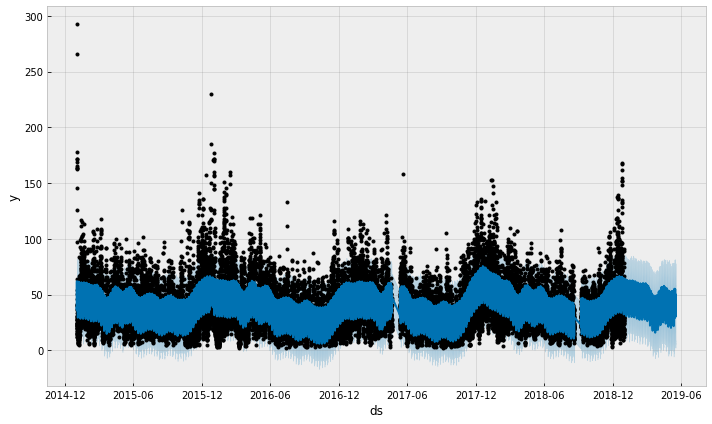

In [15]:
fig1 = modelo2.plot(forecast)

In [16]:
forecast=forecast[forecast.ds > split_date]
forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
33039,2019-01-01 01:00:00,36.316848,18.562840,62.623351,36.316848,36.316848,4.060453,4.060453,4.060453,-9.762619,...,2.767557,2.767557,2.767557,11.055515,11.055515,11.055515,0.0,0.0,0.0,40.377301
33040,2019-01-01 02:00:00,36.316735,18.033992,59.870633,36.316735,36.316735,3.493305,3.493305,3.493305,-10.368139,...,2.815813,2.815813,2.815813,11.045631,11.045631,11.045631,0.0,0.0,0.0,39.810040
33041,2019-01-01 03:00:00,36.316622,19.680837,59.423414,36.316622,36.316622,3.449481,3.449481,3.449481,-10.430485,...,2.844210,2.844210,2.844210,11.035755,11.035755,11.035755,0.0,0.0,0.0,39.766103
33042,2019-01-01 04:00:00,36.316509,20.840593,61.899148,36.316509,36.316509,4.176401,4.176401,4.176401,-9.703131,...,2.853644,2.853644,2.853644,11.025888,11.025888,11.025888,0.0,0.0,0.0,40.492910
33043,2019-01-01 05:00:00,36.316396,21.188492,63.523744,36.316396,36.316396,5.892969,5.892969,5.892969,-7.968221,...,2.845161,2.845161,2.845161,11.016030,11.016030,11.016030,0.0,0.0,0.0,42.209365


In [17]:
def make_comparison_dataframe(historical, forecast):
    """Join the history with the forecast.
    
       The resulting dataset will contain columns 'yhat', 'yhat_lower', 'yhat_upper' and 'y'.
    """
    return forecast.set_index('ds')[['yhat', 'yhat_lower', 'yhat_upper']].join(historical.set_index('ds'))

In [18]:
df_comparison=make_comparison_dataframe(test1,forecast)
df_comparison.head()

,yhat,yhat_lower,yhat_upper,y
ds,,,,
2019-01-01 01:00:00,40.377301,18.562840,62.623351,119.0
2019-01-01 02:00:00,39.810040,18.033992,59.870633,124.0
2019-01-01 03:00:00,39.766103,19.680837,59.423414,143.0
2019-01-01 04:00:00,40.492910,20.840593,61.899148,168.0
2019-01-01 05:00:00,42.209365,21.188492,63.523744,164.0


In [19]:
df_comparison.isnull().sum()

yhat            0
yhat_lower      0
yhat_upper      0
y             423
dtype: int64

In [20]:
mape(df_comparison.y, df_comparison.yhat), smape(df_comparison.y, df_comparison.yhat)

(nan, 33.27938032900803)

In [21]:
mean_squared_error(df_comparison.y, df_comparison.yhat)**0.5,mean_absolute_error(df_comparison.y, df_comparison.yhat)

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

### Box-Cow Transformation

In [22]:
train_box = train1.copy().set_index('ds')
train_box.head()

,y
ds,
2015-01-01 01:00:00,165.0
2015-01-01 02:00:00,293.0
2015-01-01 03:00:00,266.0
2015-01-01 04:00:00,178.0
2015-01-01 05:00:00,146.0


In [23]:
from scipy.stats import boxcox
train_box['y'], lambda_prophet = boxcox(train_box.y)
train_box.reset_index(inplace=True)

In [24]:
train_box.head()

,ds,y
0,2015-01-01 01:00:00,9.497973
1,2015-01-01 02:00:00,11.403732
2,2015-01-01 03:00:00,11.065612
3,2015-01-01 04:00:00,9.735943
4,2015-01-01 05:00:00,9.122446


In [25]:
modelo_box=Prophet(n_changepoints=15,
                    changepoint_prior_scale=0.6,
                    #seasonality_prior_scale = 10
                    ).fit(train_box)

In [26]:
future2 = modelo_box.make_future_dataframe(freq='H',periods=3274)
forecast2 = modelo_box.predict(future2)

#### Inverse

In [27]:
def inverse_boxcox(y, lambda_):
    return np.exp(y) if lambda_ == 0 else np.exp(np.log(lambda_ * y + 1) / lambda_)

for column in ['yhat', 'yhat_lower', 'yhat_upper']:
    forecast2[column] = inverse_boxcox(forecast2[column],
                                       lambda_prophet)

#### Errores

In [28]:
forecast2=forecast2[forecast2.ds > split_date]
df_comparison_box=make_comparison_dataframe(test1,forecast2)
df_comparison_box.head()

,yhat,yhat_lower,yhat_upper,y
ds,,,,
2019-01-01 01:00:00,32.443885,18.171805,55.072285,119.0
2019-01-01 02:00:00,31.658947,18.062128,55.873578,124.0
2019-01-01 03:00:00,31.621063,17.406793,55.021197,143.0
2019-01-01 04:00:00,32.656032,17.845883,55.831162,168.0
2019-01-01 05:00:00,34.976922,19.017500,58.911384,164.0


In [29]:
mape(df_comparison_box.y, df_comparison_box.yhat), smape(df_comparison_box.y, df_comparison_box.yhat)

(nan, 36.10928289813686)